<b>Ramdom Walks Time Series</b>

Random Walks model phenomena that come down to a stochastic decision (random step) guiding the direction. This notebook uses the random walk time series generator form tslearn to generate a data set and a NN to approximate the data series.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

import numpy as np
import math, random
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data
import torch.optim 
from torch.optim import lr_scheduler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from makesig import *
from utils import *

In [2]:
%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-08-31 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.1
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 90%


In [3]:
# Hyperparameters
HP = HYPERPARAMETERS({
    'NUM_HIDDEN_NODES'    : 95 ,
    'NUM_EXAMPLES'        : 100000 ,
    'TRAIN_SPLIT'         : .8 ,
    'MINI_BATCH_SIZE'     : 200 ,
    'NUM_EPOCHS'          : 600 ,
    'LEARNING_RATE'       : 5e-5 ,
    'LEARNING_RATE_DECAY' : 500 ,
    'WEIGHT_DECAY'        : 5e-4 ,
    'NUM_MOMENTUM'        : 0.9 ,
    'NUM_PATIENCE'        : 50 ,
    'SEED'                : 2018
})

#  torch.cuda.is_available = lambda : False            # uncomment if you want to switch GPU support off

In [4]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  
torch.manual_seed(HP.SEED);
if torch.cuda.is_available():
    torch.cuda.manual_seed(HP.SEED)

In [5]:
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
import random

dataset = random_walks(n_ts=1, sz=HP.NUM_EXAMPLES, d=1)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
y_data = scaler.fit_transform(dataset).flatten()
x_data = np.divide(np.arange(HP.NUM_EXAMPLES), HP.NUM_EXAMPLES)

In [6]:
# random shuffle data
idx = np.arange(HP.NUM_EXAMPLES)
np.random.shuffle(idx)
train_idx, validate_idx, test_idx = np.split(idx, [int(.6*len(idx)), int(.8*len(idx))]) #60%, 20%, 20% split 

x_data = np.float32(x_data).reshape(HP.NUM_EXAMPLES, 1)
y_data = np.float32(y_data).reshape(HP.NUM_EXAMPLES, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(y_data[train_idx]) # fit scaler on trainings data 
y_data = scaler.fit_transform(y_data)

train_x, train_y = x_data[train_idx], y_data[train_idx]
train_set = torch.utils.data.TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

valid_x, valid_y  = x_data[validate_idx], y_data[validate_idx]
valid_set = torch.utils.data.TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=HP.MINI_BATCH_SIZE, shuffle=True, 
                                           pin_memory=True, num_workers=0)

test_x, test_y  = x_data[test_idx], y_data[test_idx]
test_set = torch.utils.data.TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_x))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=False, num_workers=0)

train_x.shape, valid_x.shape, test_x.shape, train_y.shape, valid_y.shape, test_y.shape

((60000, 1), (20000, 1), (20000, 1), (60000, 1), (20000, 1), (20000, 1))

,x,y
count,60000.000000,60000.000000
mean,0.500065,-0.079106
std,0.288548,0.587381
min,0.000030,-1.000000
25%,0.250215,-0.572258
50%,0.500340,-0.147232
75%,0.749755,0.392276
max,0.999990,1.000000


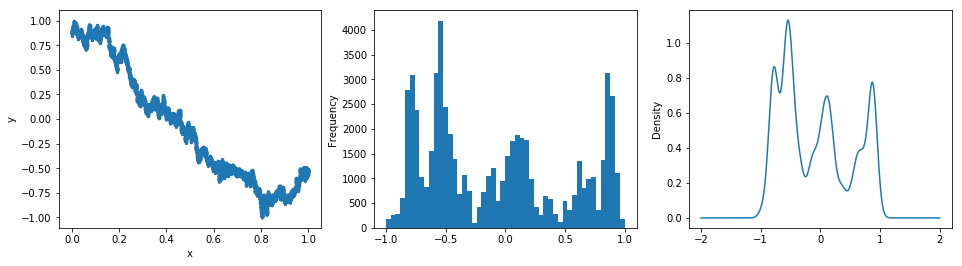

In [7]:
df = DataFrame({'x' : train_x.flatten(), 'y': train_y.flatten()})

fig, ax = plt.subplots(1,3,figsize=(16,4))

df.plot(kind='scatter', x='x', y='y', s=5.0, alpha=0.3, ax=ax[0])
df['y'].plot(kind='hist', bins=50, ax=ax[1])
df['y'].plot(kind='kde', ax=ax[2])

df.describe()

In [8]:
class UFA10(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(UFA10, self).__init__()
        self.lin1 = nn.Linear(D_in, H)
        self.lin2 = nn.Linear(H, H, bias=False)
        self.lin21 = nn.Linear(H, H, bias=False)
        self.lin22 = nn.Linear(H, H, bias=False)
        self.lin23 = nn.Linear(H, H, bias=False)
        self.lin3 = nn.Linear(H, D_out)
        
        self.bc1 = nn.BatchNorm1d(H, affine=True)
        self.bc2 = nn.BatchNorm1d(H, affine=True)
        self.bc21 = nn.BatchNorm1d(H, affine=True)
        self.bc22 = nn.BatchNorm1d(H, affine=True)
        self.bc23 = nn.BatchNorm1d(H, affine=True)
    
    def forward(self, x):
        h = self.lin1(x)
        h = self.bc1(h)
        h = F.leaky_relu(h) 
        
        shortcut = h
        
        h = self.lin2(h)
        h = self.bc2(h)
        h = F.leaky_relu(h)
                
        h = self.lin21(h)
        h = self.bc21(h)
        h = F.leaky_relu(h)

        #h = h + shortcut

        h = self.lin22(h)
        h = self.bc22(h)
        h = F.leaky_relu(h)
        
        h = self.lin23(h)
        h = self.bc23(h)
        h = F.leaky_relu(h)

        h = h + shortcut
        
        h = self.lin3(h)
        y = F.tanh(h) 
        return y

In [9]:
model = UFA10(train_x.shape[1], HP.NUM_HIDDEN_NODES, train_y.shape[1])

glorot_weight_zero_bias(model)

if torch.cuda.is_available():
    model.cuda()

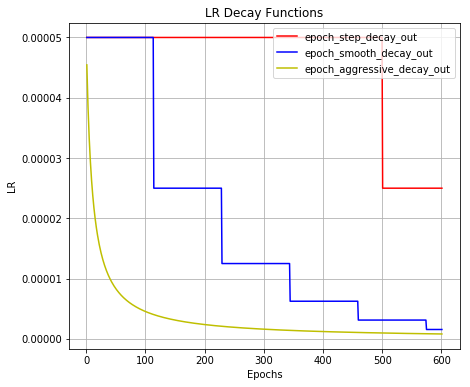

In [10]:
# Plot different learnings rate schedules
%matplotlib inline

epoch_step_decay = lambda epoch: HP.LEARNING_RATE * (0.5**(epoch // HP.LEARNING_RATE_DECAY))
epoch_smooth_decay = lambda epoch: HP.LEARNING_RATE * math.pow(0.5, math.floor((1 + epoch) / 115.0))
epoch_aggressive_decay = lambda epoch: HP.LEARNING_RATE * 1 / (1  + epoch * 1e-1/1 )

epts = np.linspace(1, HP.NUM_EPOCHS+1, HP.NUM_EPOCHS)

epoch_step_decay_out = np.vectorize(epoch_step_decay)(epts)
epoch_smooth_decay_out = np.vectorize(epoch_smooth_decay)(epts)
epoch_aggressive_decay_out = np.vectorize(epoch_aggressive_decay)(epts)

plt.figure(figsize=(7,6))
plt.plot(epts,epoch_step_decay_out, label='epoch_step_decay_out', color='r')
plt.plot(epts,epoch_smooth_decay_out, label='epoch_smooth_decay_out', color='b')
plt.plot(epts,epoch_aggressive_decay_out, label='epoch_aggressive_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [11]:
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=HP.LEARNING_RATE, 
                            momentum=HP.NUM_MOMENTUM, 
                            weight_decay=HP.WEIGHT_DECAY, 
                            nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[epoch_step_decay])  # select the LR schedule
stopping = Stopping(model, patience= HP.NUM_PATIENCE)

<IPython.core.display.Javascript object>


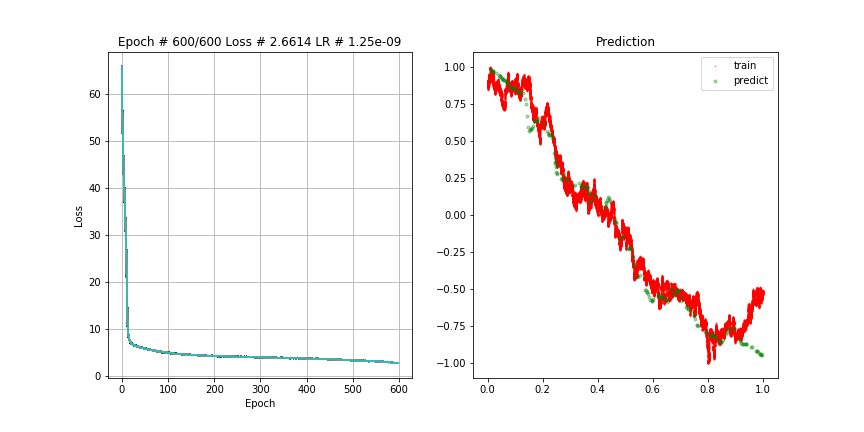

Epoch: 100%|██████████| 600/600 [29:22<00:00,  2.94s/it, loss=2.66, lr=1.25e-09]

Model training took 1762.50 seconds.
=> saved checkpoint './chkp/MLP1-checkpoint.tar' (epoch 600)


{'LEARNING_RATE': 5e-05,
 'LEARNING_RATE_DECAY': 500,
 'MINI_BATCH_SIZE': 200,
 'NUM_EPOCHS': 600,
 'NUM_EXAMPLES': 100000,
 'NUM_HIDDEN_NODES': 95,
 'NUM_MOMENTUM': 0.9,
 'NUM_PATIENCE': 50,
 'SEED': 2018,
 'TRAIN_SPLIT': 0.8,
 'WEIGHT_DECAY': 0.0005}

In [12]:
%matplotlib notebook

model.train()

pl = PlotLosses()

train_losses = []
valid_losses = []
valid_score = []
start = time.time()
epoch_iter = tqdm(range(1, HP.NUM_EPOCHS + 1))
for epoch in epoch_iter:
    epoch_iter.set_description('Epoch')

    with DelayedKeyboardInterrupt():

        scheduler.step()

        batch_idx, loss_avg = 0, 0
        for batch_idx, (data, target) in enumerate(train_loader):

            y_pred = model(to_var(data, async=True)) # predict y based on x
            loss = criterion(y_pred, to_var(target)) # compute loss

            optimizer.zero_grad() # clear gradients
            loss.backward() # compute gradients
            optimizer.step() # apply gradients

            loss_avg += loss.item()

        loss_avg /= batch_idx+1
        train_losses.append(loss_avg)
        
        batch_idx, loss_avg, score = 0, 0, 0
        for batch_idx, (data, target) in enumerate(valid_loader):

            y_pred = model(to_var(data, async=True)) # predict y based on x
            loss = criterion(y_pred, to_var(target)) # compute loss

            optimizer.zero_grad() # clear gradients
            loss.backward() # compute gradients
            optimizer.step() # apply gradients

            loss_avg += loss.item()
            score += r2_score(to_np(target), to_np(y_pred))

        loss_avg /= batch_idx+1
        valid_losses.append(loss_avg)
        valid_score.append(score)
        
        pl.plot_loss(train_losses, epoch, HP.NUM_EPOCHS, scheduler.get_lr()[0])
        pl.plot_prediction(train_x, train_y, data.numpy(), to_np(y_pred))

        stopping_flag = stopping.step(epoch, valid_losses[-1], valid_score[-1])
        
        epoch_iter.set_postfix(loss=train_losses[-1], lr=scheduler.get_lr()[0])
        
        if stopping_flag:
            print("Early stopping at epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))
            break
            
print("Model training took %.2f seconds." % (time.time() - start))

save_checkpoint({
    'model' : type(model).__name__,
    'hyperparameters' : HP,
    'epoch': epoch,
    'loss' : loss.item(),
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
},
    filename='./chkp/MLP1-checkpoint.tar')

display(HP)

pl.close()

In [13]:
%matplotlib inline

net = UFA10(test_x.shape[1], HP.NUM_HIDDEN_NODES, test_y.shape[1])

checkpoint = load_checkpoint(net, filename='./chkp/MLP1-checkpoint.tar')
display("Name: " + checkpoint['model'],
        "Epoch: %d" % checkpoint['epoch'],
        "Loss: %.4f" % checkpoint['loss'],
        checkpoint['hyperparameters'])

net.eval()

if torch.cuda.is_available():
    net.cuda()
    
y_pred = []
for data, target in test_loader:
    
    output = net(to_var(data))

    y_pred.append(to_np(output)[0])

y_pred = np.array(y_pred)

=> loaded checkpoint './chkp/MLP1-checkpoint.tar' (epoch 600)


'Name: UFA10'

'Epoch: 600'

'Loss: 3.0259'

{'LEARNING_RATE': 5e-05,
 'LEARNING_RATE_DECAY': 500,
 'MINI_BATCH_SIZE': 200,
 'NUM_EPOCHS': 600,
 'NUM_EXAMPLES': 100000,
 'NUM_HIDDEN_NODES': 95,
 'NUM_MOMENTUM': 0.9,
 'NUM_PATIENCE': 50,
 'SEED': 2018,
 'TRAIN_SPLIT': 0.8,
 'WEIGHT_DECAY': 0.0005}

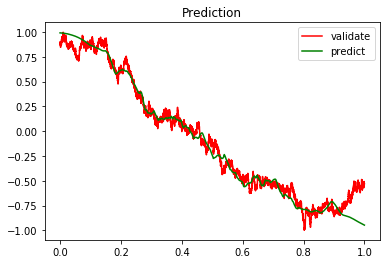

In [14]:
plot_prediction(test_x, test_y, test_x, y_pred, "Prediction", "validate", "predict")

In [15]:
stat_summary(test_y.flatten(), y_pred.flatten(), test_y.shape[0], sum([np.prod(p.size()) for p in net.parameters()]))


Date:  Fri, 31 Aug 2018
Time:  19:37:49
Parameters:                37336           Cases: 20000
Models stats
Mean Squared Error         0.010464         
Mean Absolute Error        0.010464         
Root Mean Squared Error    0.102292         
R-squared                  0.969862         


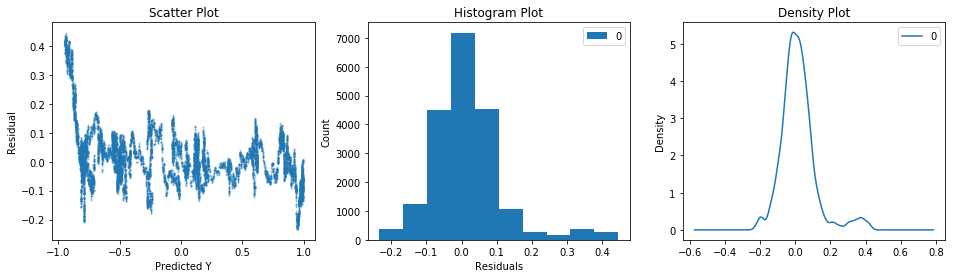

In [16]:
residual_plots(test_y.flatten(), y_pred.flatten())

In [17]:
print_summary(model)

Summary for model: UFA10
_________________________________________________________________
Layer (type)                 Shape                     Param #   
lin1 (Linear)                ((95, 1), (95,))          190       
_________________________________________________________________
lin2 (Linear)                ((95, 95),)               9025      
_________________________________________________________________
lin21 (Linear)               ((95, 95),)               9025      
_________________________________________________________________
lin22 (Linear)               ((95, 95),)               9025      
_________________________________________________________________
lin23 (Linear)               ((95, 95),)               9025      
_________________________________________________________________
lin3 (Linear)                ((1, 95), (1,))           96        
_________________________________________________________________
bc1 (BatchNorm1d)            ((95,), (95,))        

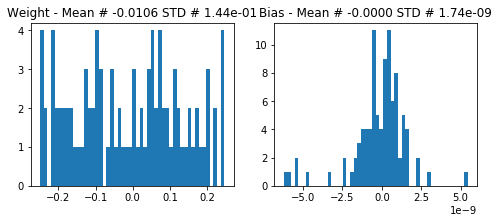

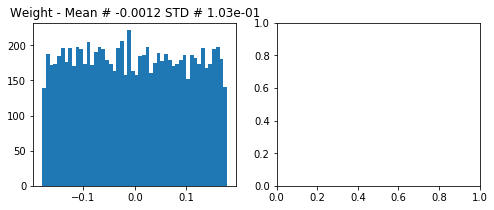

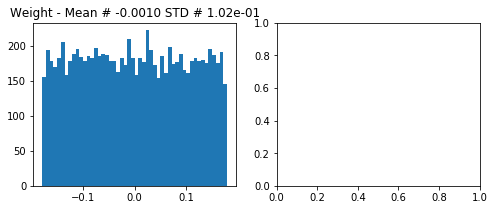

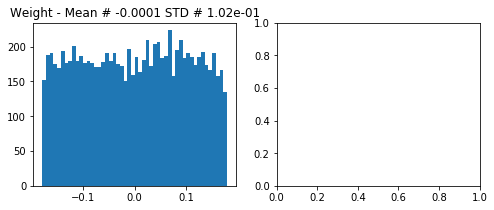

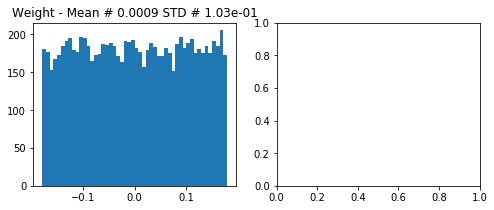

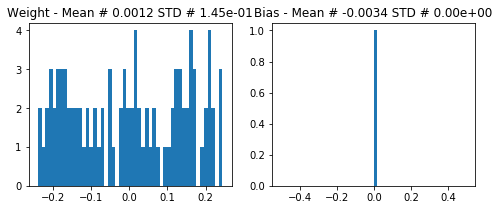

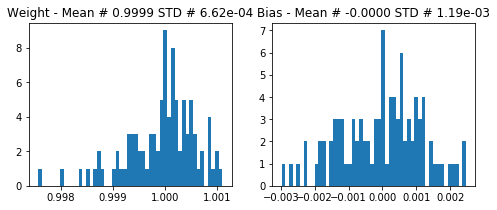

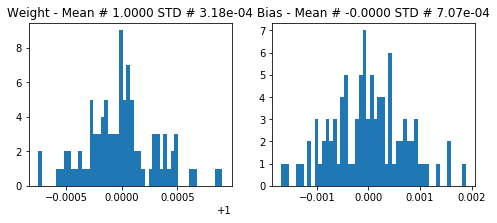

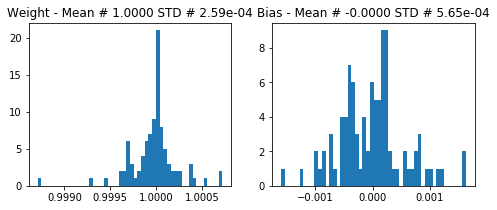

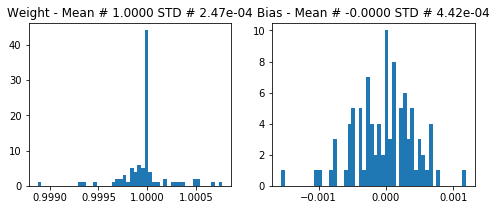

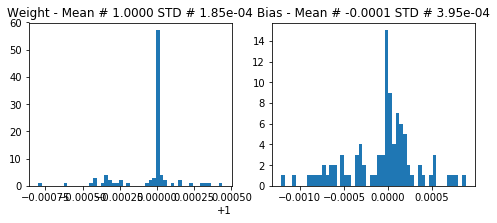

In [18]:
layer_stats(model)

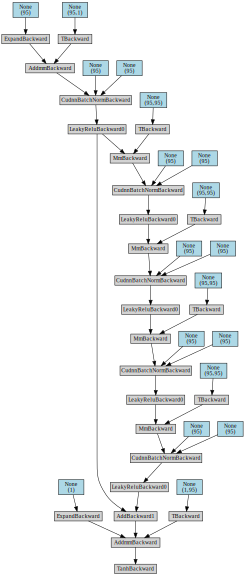

In [19]:
make_dot(output, net.state_dict())